### Segmenting Captured Tree Images

In [2]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from scipy import signal, misc, ndimage
from PIL import Image, ImageFilter
from skimage import filters, feature, img_as_float
from skimage.io import imread, imsave
from skimage.color import rgb2gray, gray2rgb

In [3]:
def plot_image(image, title):
    plt.imshow(image, 'gray')
    plt.title(title, size=20)
    plt.axis('off')

c:\Users\kipli\miniconda3\envs\images2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
c:\Users\kipli\miniconda3\envs\images2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


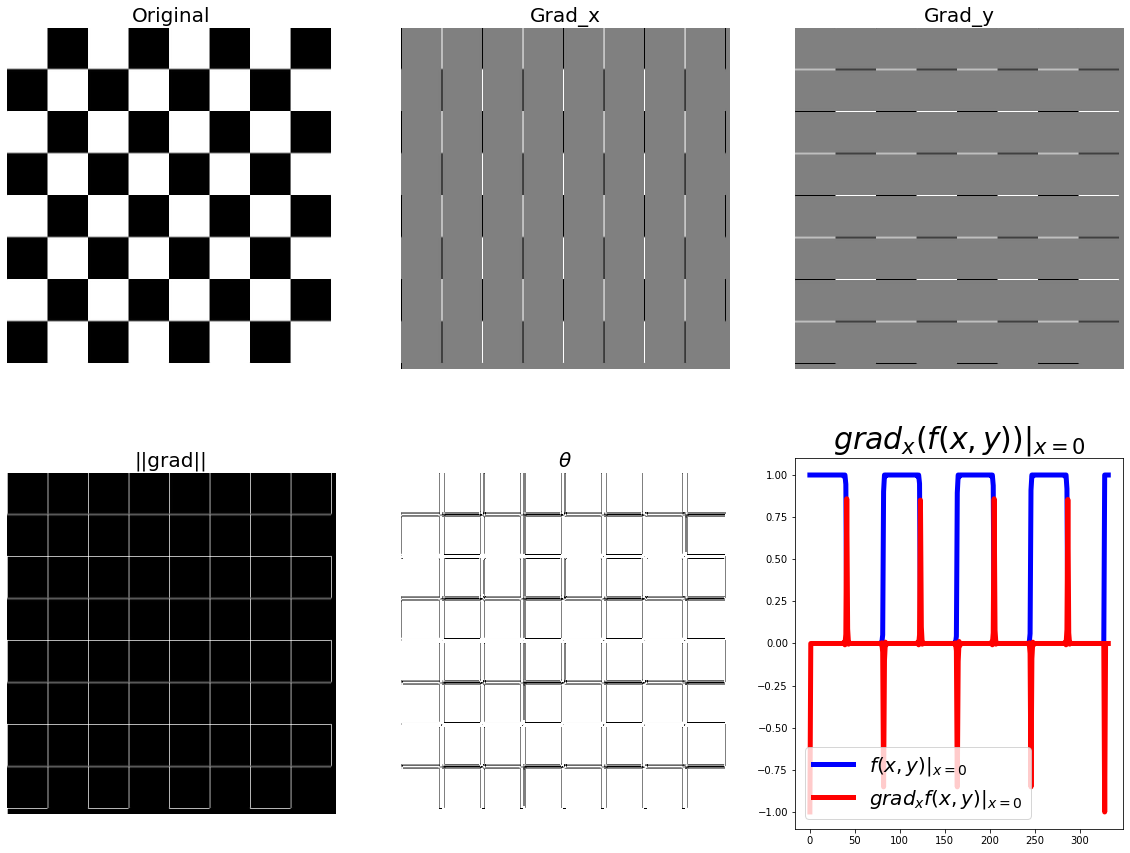

In [18]:
ker_x = [[-1, 1]]
ker_y = [[-1], [1]]
im = rgb2gray(imread('images/packt_images/chess.png')[:,:,:3])
im_x = signal.convolve2d(im, ker_x, mode='same')
im_y = signal.convolve2d(im, ker_y, mode='same')
im_mag = np.sqrt(im_x**2 + im_y**2)
im_dir = np.arctan(im_y / im_x)

plt.figure(figsize=(20, 15))
plt.subplot(231), plot_image(im, 'Original')
plt.subplot(232), plot_image(im_x, 'Grad_x')
plt.subplot(233), plot_image(im_y, 'Grad_y')
plt.subplot(234), plot_image(im_mag, '||grad||')
plt.subplot(235), plot_image(im_dir, r'$\theta$')
plt.subplot(236)
plt.plot(range(im.shape[1]), im[0,:], 'b-', label=r'$f(x,y) |_{x=0}$', linewidth=5)
plt.plot(range(im.shape[1]), im_x[0,:], 'r-', label=r'$grad_x f(x,y)|_{x=0}$', linewidth=5)
plt.title(r'$grad_x (f(x,y))|_{x=0}$', size=30)
plt.legend(prop={'size': 20})
plt.show()

### Sharpening with Laplacian

In [10]:
im = imread('trees/left_1.png')
im_r = im[:,:,0]
im_g = im[:,:,1]
im_b = im[:,:,2]


kernel1 = np.array([[0,1,0],[1,-4,1],[0,1,0]], np.dtype(np.int32))
kernel2 = np.array([[1,1,1],[1,-8,1],[1,1,1]], np.dtype(np.int32))
im_lap_r = signal.convolve2d(im_r, kernel2, mode='same')
im_lap_g = signal.convolve2d(im_g, kernel2, mode='same')
im_lap_b = signal.convolve2d(im_b, kernel2, mode='same')

im_lap_r[im_lap_r < 0] = 0
im_lap_g[im_lap_g < 0] = 0
im_lap_b[im_lap_b < 0] = 0

im_lap_r = im_lap_r.reshape((720, 1280))
im_lap_g = im_lap_g.reshape((720, 1280))
im_lap_b = im_lap_b.reshape((720, 1280))

sharpened_r = im_r - im_lap_r
sharpened_g = im_g - im_lap_g
sharpened_b = im_b - im_lap_b

sharpened_r[sharpened_r < 0] = 0
sharpened_g[sharpened_g < 0] = 0
sharpened_b[sharpened_b < 0] = 0

sharpened = np.dstack((sharpened_r, sharpened_g, sharpened_b))

plt.figure(figsize=(15, 7))
plt.subplot(121), plot_image(im, 'Original')
plt.subplot(122), plot_image(sharpened, 'Sharpened')
plt.show()

(540, 466)


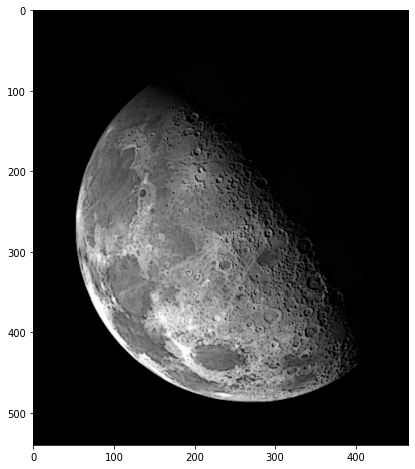

In [4]:
im = imread('DIP3E_Original_Images_CH03/Fig0338(a)(blurry_moon).tif')
print(im.shape)
kernel1 = np.array([[0,1,0],[1,-4,1],[0,1,0]])
kernel2 = np.array([[1,1,1],[1,-8,1],[1,1,1]])
im_lap = signal.convolve2d(im, kernel2, mode='same')
# im_lap = ndimage.laplace(im)
im_lap[im_lap < 0] = 0
im_lap = im_lap.reshape((540, 466))
sharpened = im - im_lap
sharpened[sharpened < 0] = 0
plt.figure(figsize=(8,8))
plt.imshow(sharpened, 'gray')
plt.show()

In [13]:
ims = glob.glob('trees/*.png')
kernel1 = np.array([[0,1,0],[1,-4,1],[0,1,0]], np.dtype(np.int32))
kernel2 = np.array([[1,1,1],[1,-8,1],[1,1,1]], np.dtype(np.int32))

def sharpen(images, kernel):

    for image in images:
        img = imread(image)

        # 1. Separate the image channels for separate processing
        img_chs = [img[:,:,i] for i in range(img.shape[-1])]
        
        # 2. Apply the Laplacian Filter on each channel
        lap_chs = [signal.convolve2d(img_ch, kernel, mode='same') for img_ch in img_chs]


        # 2.1 Clip channels at 0 to remove negative pixels
        for lap_channel in lap_chs:
            lap_channel[lap_channel < 0] = 0
            lap_channel = lap_channel.reshape(img_chs[0].shape)
        
        # 3. Subtract laplacian from corresponding channel i.e. new_channel = original_channel - laplacian
        sharpened_channels = [img_ch - lap_ch for img_ch, lap_ch in zip(img_chs, lap_chs)]

        # 3.1 Clip each new channel at 0 to remove negative pixels
        for sharpened_channel in sharpened_channels:
            sharpened_channel[sharpened_channel < 0] = 0
        
        # 3.2 Assemble the 3 sharpened channels together to form RGB image and save
        sharpened = np.dstack(tuple(sharp_channel for sharp_channel in sharpened_channels))
        sharpened = np.uint8(sharpened)
        imsave('trees/sharpened/sharpened_' + image.split('\\')[-1], sharpened, check_contrast=False)

sharpen(ims, kernel2)


### Unsharp Masking

In [4]:
ims = glob.glob('trees/*.png')

def unsharp_mask(images):

    for image in images:
        img = imread(image)

        # 1. Separate the image channels for separate processing
        img_chs = [img[:,:,i] for i in range(img.shape[-1])]
        
        # 2. Blur the original image channels
        blurred_chs = [cv2.GaussianBlur(img_ch, (31,31), 5) for img_ch in img_chs]
        
        # 3. Subtract blurred channel from original channel i.e. channel_mask = original_channel - blurred channel
        channel_masks = [img_ch - blurred_ch for img_ch, blurred_ch in zip(img_chs, blurred_chs)]
        
        # 4. Add mask to original image
        sharpened_channels = [img_ch + channel_mask for img_ch, channel_mask in zip(img_chs, channel_masks)]

        # 4.1 Assemble the 3 sharpened channels together to form RGB image and save
        sharpened = np.dstack(tuple(sharp_channel for sharp_channel in sharpened_channels))
        # sharpened = np.uint8(sharpened)
        imsave('trees/unsharp_masked/sharpened_' + image.split('\\')[-1], sharpened, check_contrast=False)

unsharp_mask(ims)


#### Masking Images

In [11]:
# images
imgL = cv2.imread('trees/sharpened/sharpened_left_1.png', 0)
imgR = cv2.imread('trees/sharpened/sharpened_right_1.png', 0)

# masks
maskL = cv2.imread('trees/matlab_masks/mask_left_1.png', 0)
maskR = cv2.imread('trees/matlab_masks/mask_right_1.png', 0)

assert(imgR.shape == maskR.shape)

In [ ]:
imgL[maskL <= 1] = 0
imgR[maskR <= 1] = 0

plt.figure(figsize=(10, 12))
plt.subplot(211)
plot_image(imgL, 'Masked')
plt.subplot(212)
plot_image(imgR, 'Masked')

In [33]:
# images
left_ims = glob.glob('trees/sharpened/sharpened_left_*.png')
right_ims = glob.glob('trees/sharpened/sharpened_right_*.png')

# masks
left_masks = glob.glob('trees/matlab_masks/mask_left_*.png')
right_masks = glob.glob('trees/matlab_masks/mask_right_*.png')

assert(len(left_ims) == len(right_ims))
assert(len(left_masks) == len(right_masks))


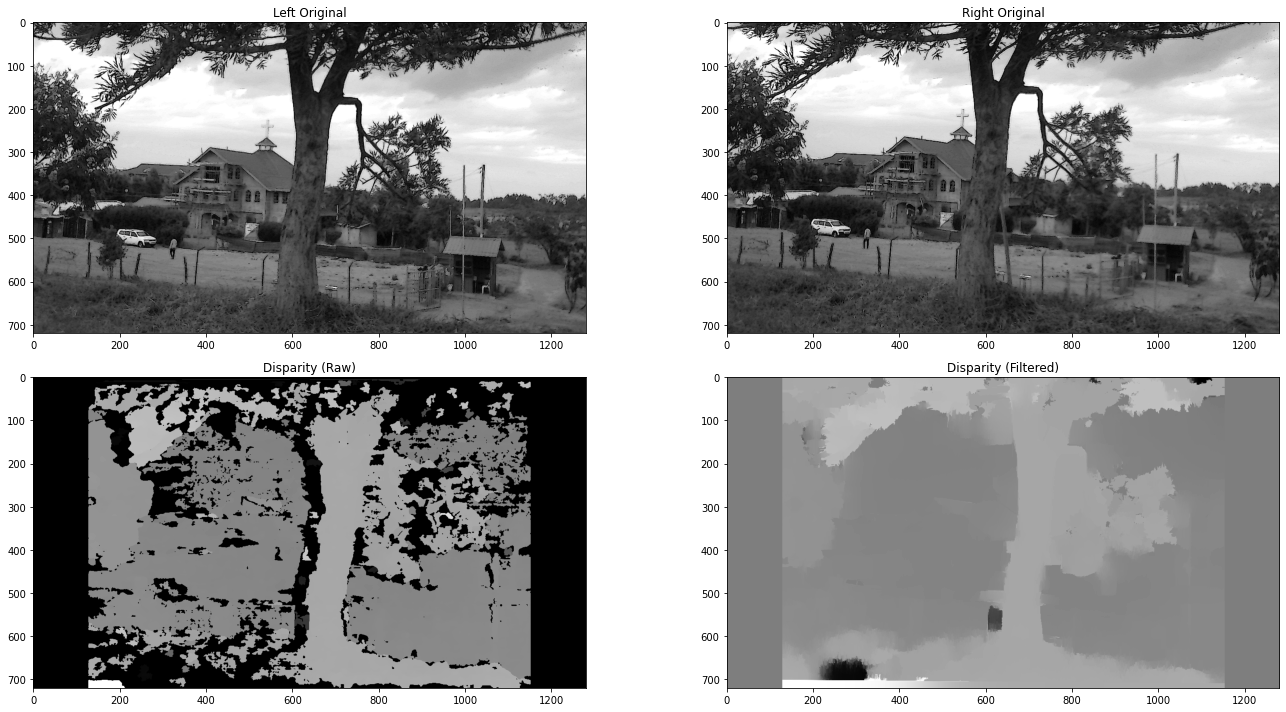

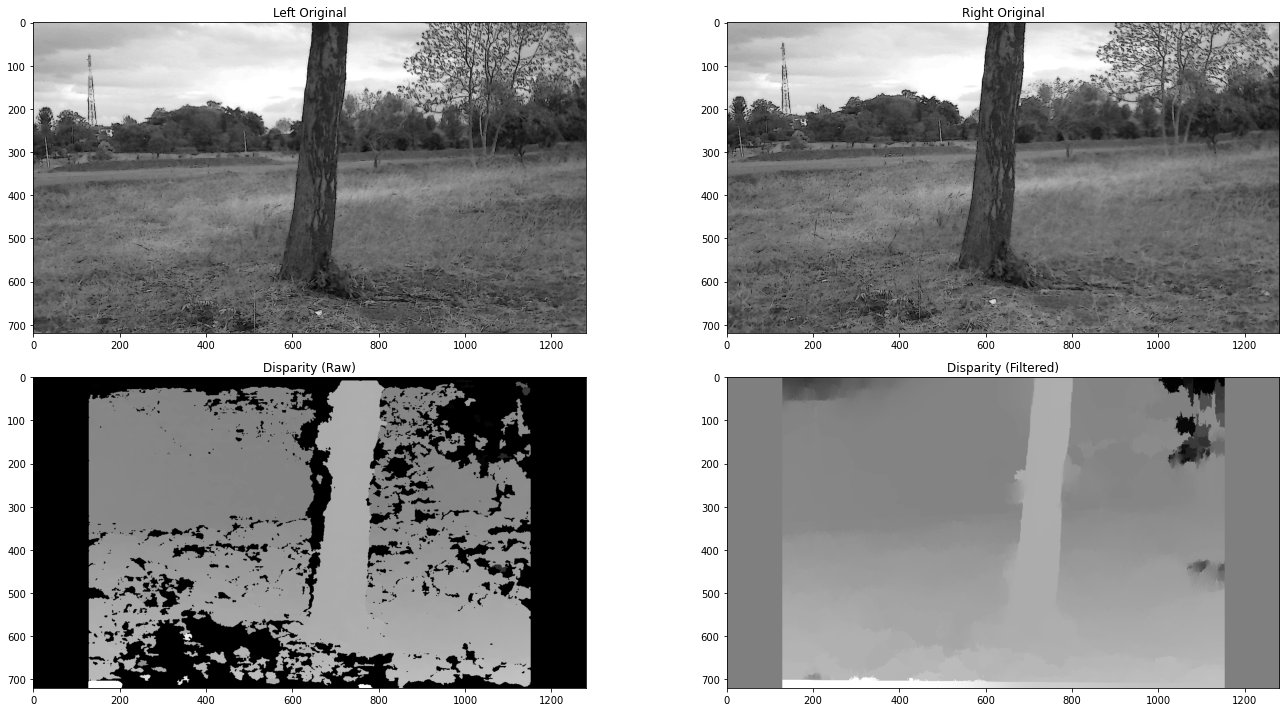

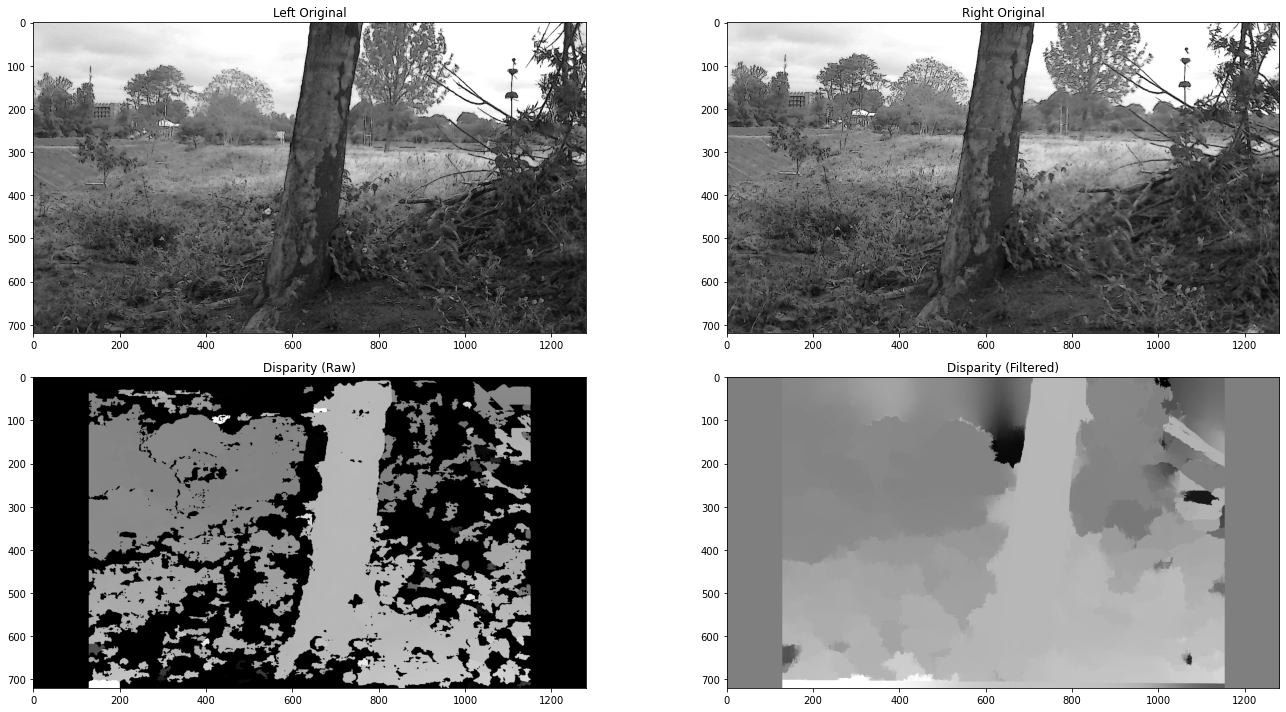

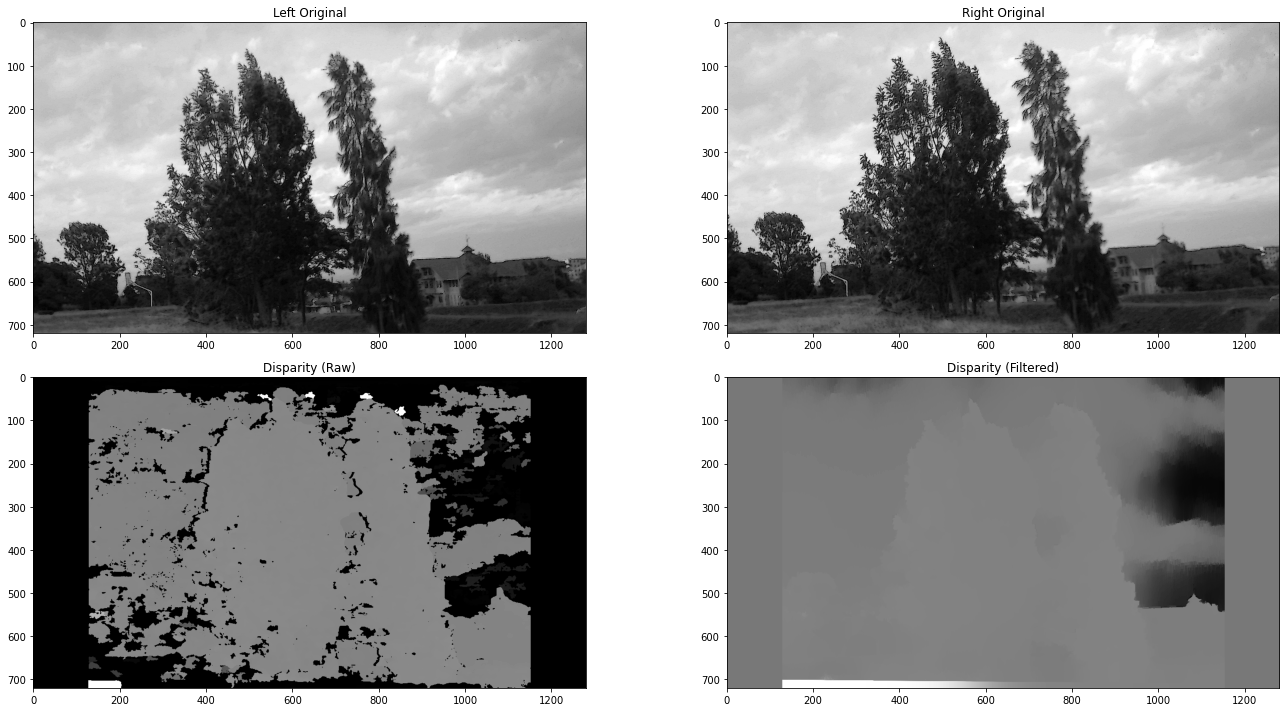

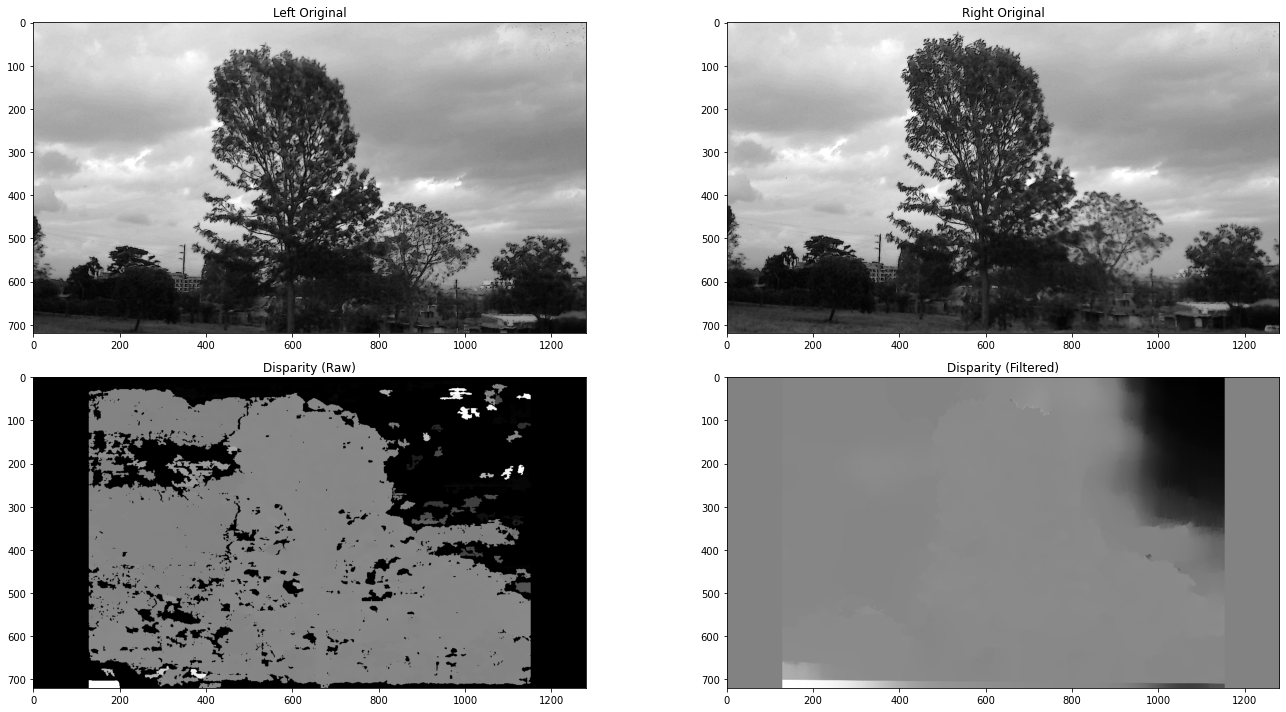

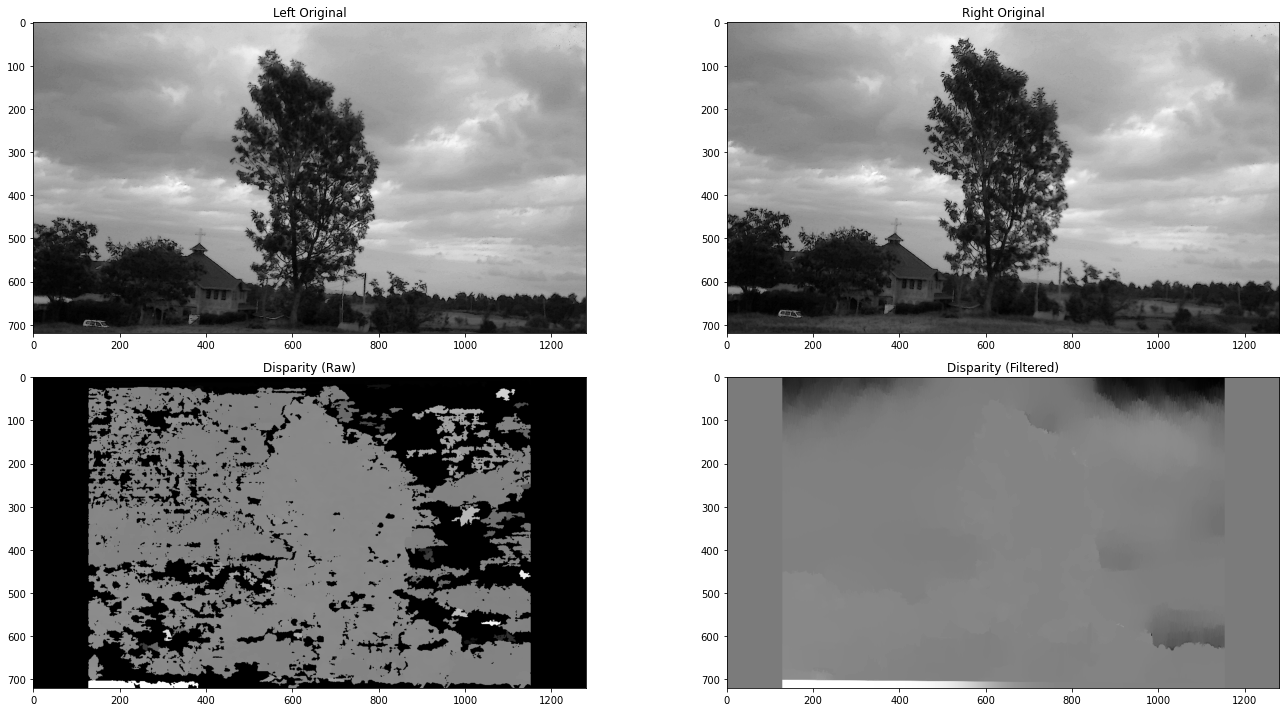

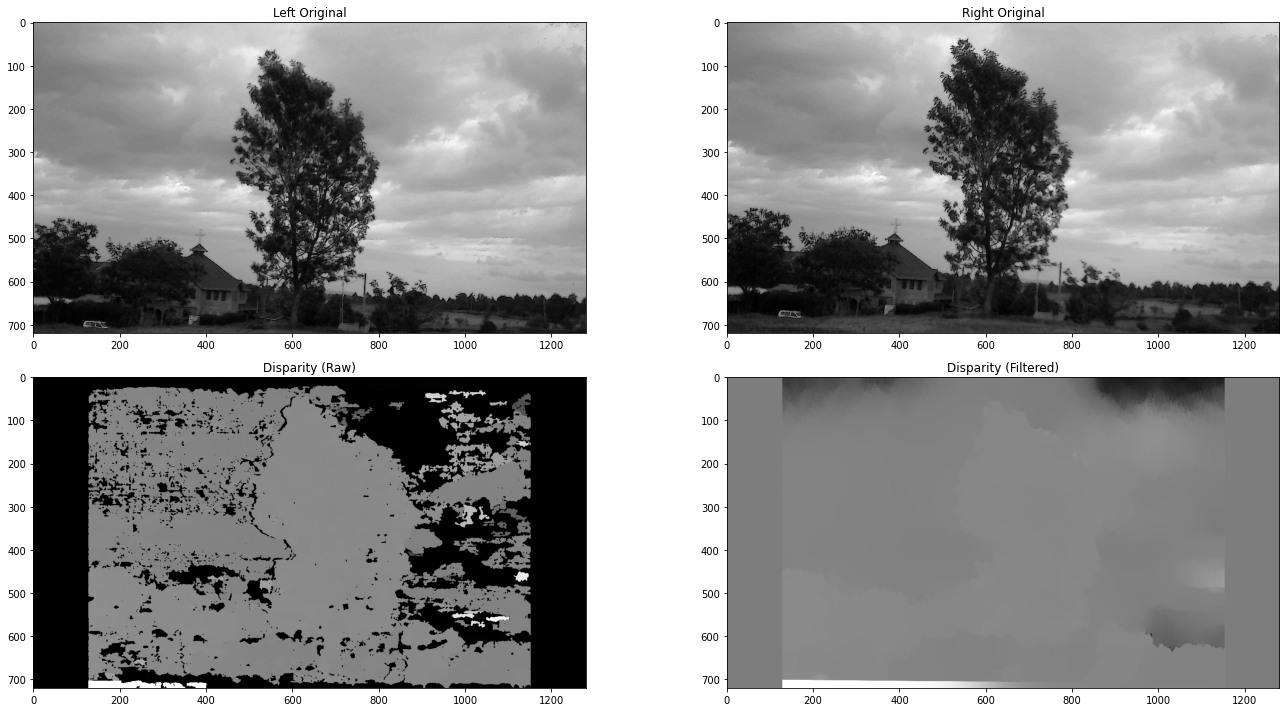

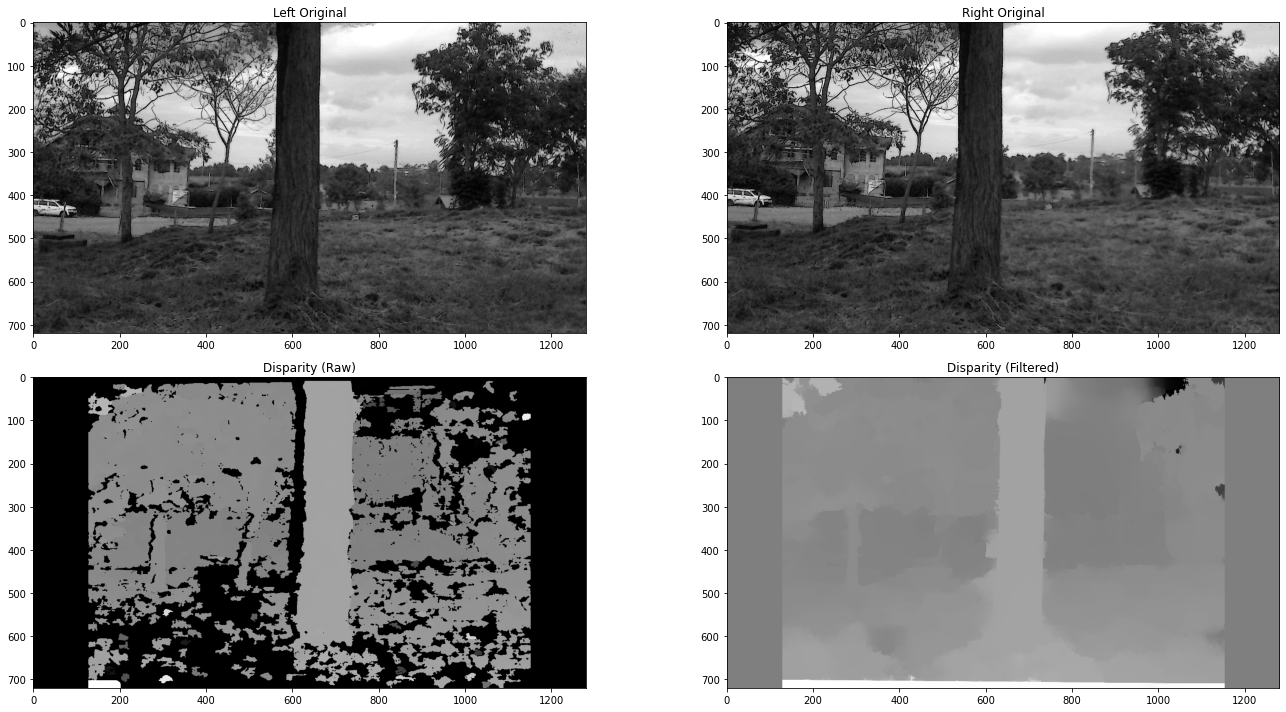

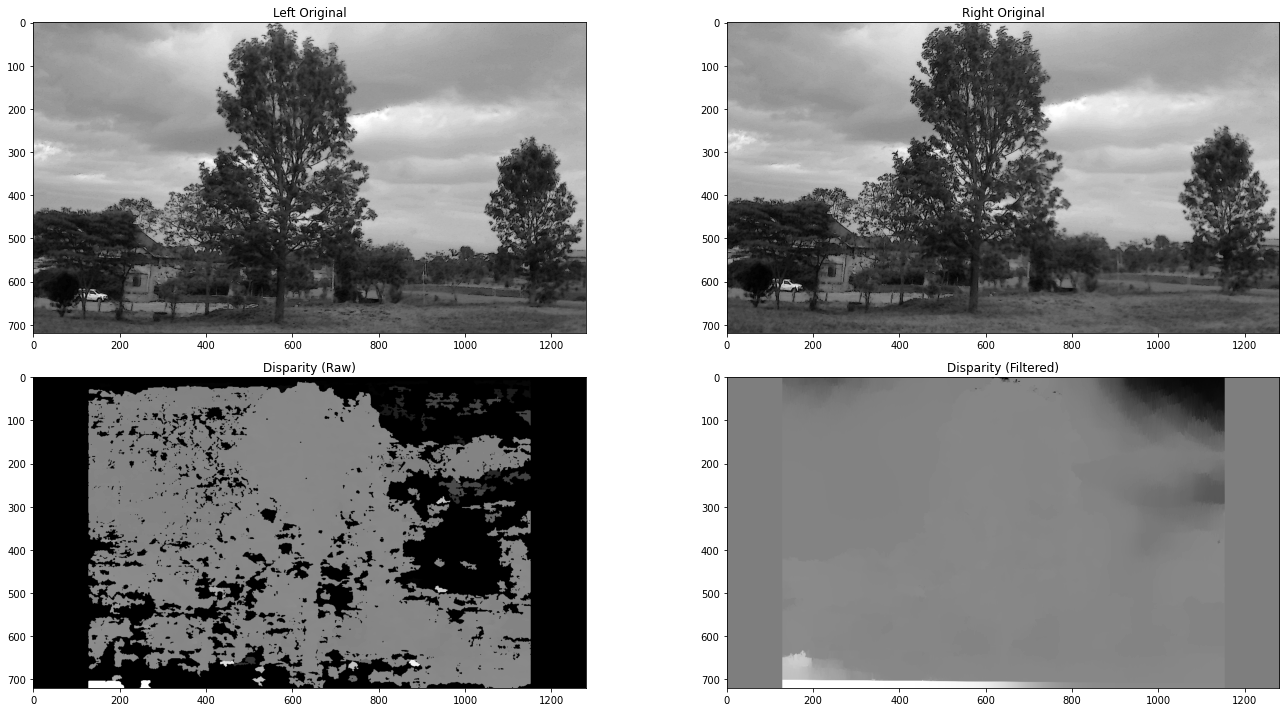

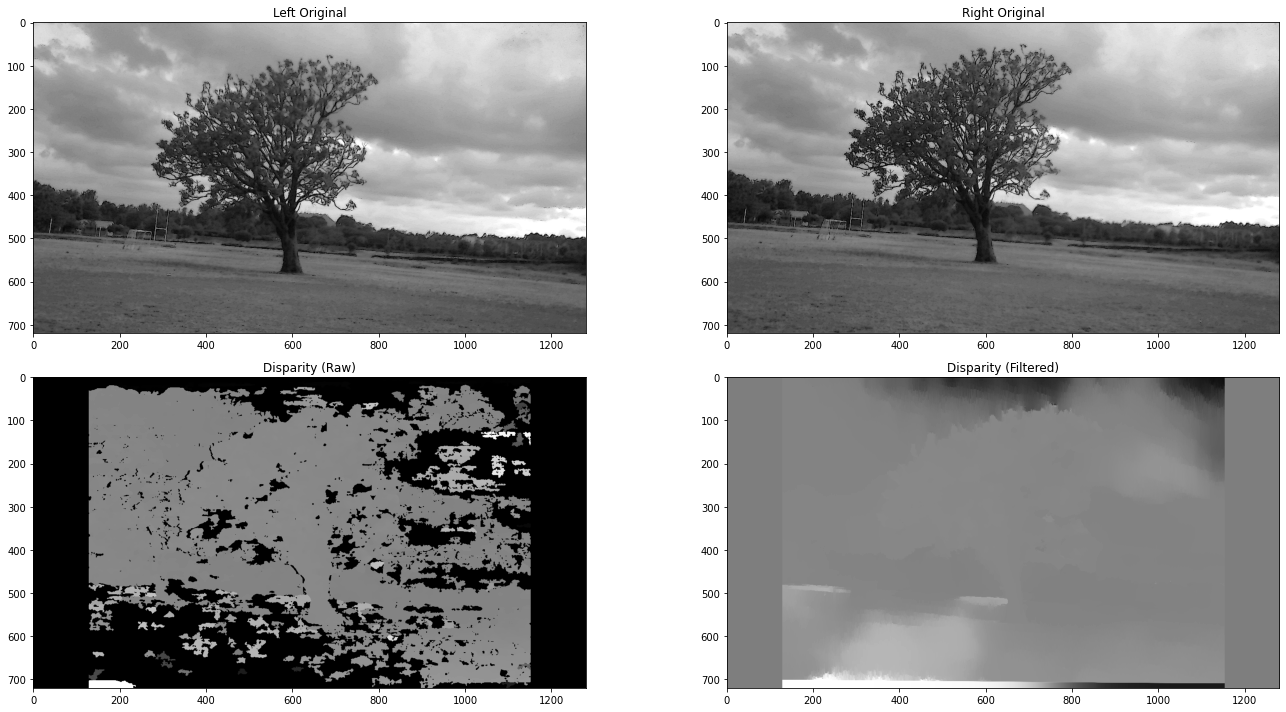

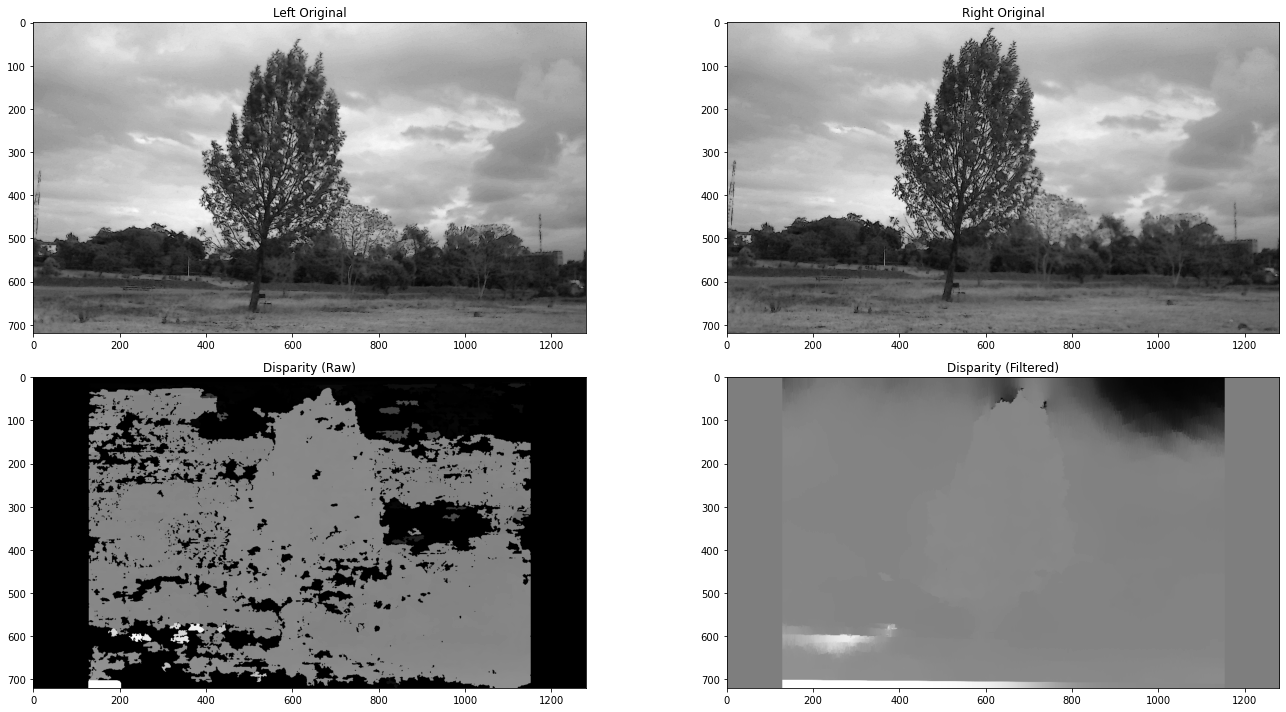

In [40]:
from skimage.morphology import erosion, dilation, opening, closing, disk


# ------------------------------------- #
# SETUP
# ------------------------------------- #

# read camera data
data = cv2.FileStorage('stereo_params_v7.yml', cv2.FILE_STORAGE_READ)
keys = ["K1", "K2", "D1", "D2", "R1", "R2", "P1", "P2", "T"]
[K1, K2, D1, D2, R1, R2, P1, P2, T] = [data.getNode(key).mat() for key in keys]

'''
We know that

        |f  0   cx1  0|
P1 =    |0  f   cy   0|
        |0  f   1    0|

and 

        |f  0   cx2  Tx*f|
P2 =    |0  f   cy   0   |
        |0  f   1    0   |

and in our case, cx1 = cx2 = cx
'''

f = K1[0,0]
Tx = T[0,0]
P1 = np.hstack((K1, np.array([[0],[0],[0]])))
P2 = np.hstack((K2, np.array([[Tx*f],[0],[0]])))


# ------------------------------------- #
# STEREO RECTIFICATION
# ------------------------------------- #
i = 1
for file_L, file_R, mask_file_L in zip(left_ims, right_ims, left_masks):

        imgL = cv2.imread(file_L, 0)
        imgR = cv2.imread(file_R, 0)
        maskL = cv2.imread(mask_file_L, 0)

        h1, w1 = imgL.shape
        h2, w2 = imgR.shape


        # rectify images using initUndistortRectifyMap
        xmap1, ymap1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (w1,h1), cv2.CV_32FC1)
        xmap2, ymap2 = cv2.initUndistortRectifyMap(K2, D2, R2, P2, (w1,h1), cv2.CV_32FC1)

        imgL_rectified = cv2.remap(imgL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        maskL_rectified = cv2.remap(maskL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        imgR_rectified = cv2.remap(imgR, xmap2, ymap2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        remap_combined = np.hstack((imgL_rectified, imgR_rectified))

        # Plot the Rectified Images
        # fig, axes = plt.subplots(figsize=(12,3.5))
        # axes.imshow(remap_combined, 'gray')
        # axes.hlines((200, 300, 400, 500, 600), xmin=0, xmax=2559)
        # plt.suptitle("Rectified Images")
        # plt.show()


        # -------------------------------- #
        # COMPUTE DISPARITY MAP
        # -------------------------------- #

        # Matched blocked size
        block_size = 11
        min_disp = -128
        max_disp = 128

        num_disp = max_disp - min_disp
        uniquenessRatio = 5
        speckleWindowSize = 200
        speckleRange = 2
        disp12MaxDiff = 0

        stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=block_size,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        speckleRange=speckleRange,
        disp12MaxDiff=disp12MaxDiff,
        P1=8 * block_size * block_size,
        P2=32 * block_size * block_size
        )

        disparity_SGBM = stereo.compute(imgL_rectified, imgR_rectified)
        disparity_SGBM = cv2.normalize(disparity_SGBM,
                                disparity_SGBM,
                                beta=0,
                                alpha=255,
                                norm_type=cv2.NORM_MINMAX)
        disparity_SGBM = np.uint8(disparity_SGBM)
        # cv2.imwrite('disparitySGBM.png', disparity_SGBM)


        # -------------------------------- #
        # FILTER DISPARITY MAP
        # -------------------------------- #
        right_matcher = cv2.ximgproc.createRightMatcher(stereo)
        # filter parameters
        lmbda = 8000
        sigma = 1.5
        visual_multiplier = 6

        wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
        wls_filter.setLambda(lmbda)
        wls_filter.setSigmaColor(sigma)
        dispL = stereo.compute(imgL_rectified, imgR_rectified)

        # erode and dilate dispL
        selem = disk(8)
        dispL = closing(opening(dispL, selem), selem)
        dispR = right_matcher.compute(imgR_rectified, imgL_rectified)

        # erode and dilate dispR
        dispR = closing(opening(dispR, selem), selem)
        dispL = np.int16(dispL)
        dispR = np.int16(dispR)

        filteredImg = wls_filter.filter(dispL, imgL_rectified, None, dispR)

        # Normalize the values to the range 0-255 for a grayscale image
        filteredImg = cv2.normalize(filteredImg,
                                filteredImg,
                                beta=0,
                                alpha=255,
                                norm_type=cv2.NORM_MINMAX)
        filteredImg = np.uint8(filteredImg)
        # cv2.imwrite('filteredSGBM.png', filteredImg)

        # Plot original images and depth maps side by side
        plt.figure(figsize=(20,10))
        plt.subplot(221), plt.imshow(imgL, 'gray'), plt.title('Left Original')
        plt.subplot(222), plt.imshow(imgR, 'gray'), plt.title('Right Original')
        plt.subplot(223), plt.imshow(disparity_SGBM, 'gray'), plt.title('Disparity (Raw)')
        plt.subplot(224), plt.imshow(filteredImg, 'gray'), plt.title('Disparity (Filtered)')
        plt.show()

        # save disparity maps
        cv2.imwrite('trees/filtered_disparity_maps/filtered_disparity_' + str(i) + '.png', filteredImg)
        filteredImg[maskL_rectified == 0] = 0
        cv2.imwrite('trees/masked_disparity_maps/masked_disparity_' + str(i) + '.png', filteredImg)
        i += 1


In [30]:
def mouse_event(event):
   print('x: {} and y: {}'.format(event.xdata, event.ydata))

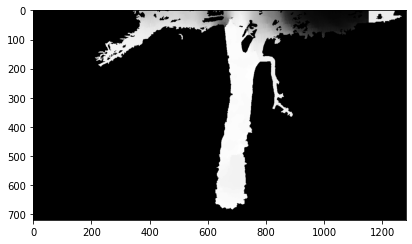

In [38]:
maskL_rectified = cv2.remap(maskL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

filteredImg[maskL_rectified == 0] = 0
plt.imshow(filteredImg, 'gray')
plt.show()

In [18]:
# Plot the Rectified Images
fig, axes = plt.subplots(figsize=(15,7))
axes.imshow(remap_combined, 'gray')
axes.hlines((200, 300, 400, 500, 600), xmin=0, xmax=2559)
plt.title("Rectified Images")
plt.show()

In [32]:
a = np.array([[0,1,0],[2,4,0],[0,2,0]])
(rows,cols) = a.nonzero()
d = zip(rows,cols)
d = list(d)
print(a)
print(d)

[[0 1 0]
 [2 4 0]
 [0 2 0]]
[(0, 1), (1, 0), (1, 1), (2, 1)]


In [34]:
base = [(x,y) for x,y in d if x == rows.max()][0]
top = [(x,y) for x,y in d if x == rows.min()][0]
left = [(x,y) for x,y in d if y == cols.min()][0]
right = [(x,y) for x,y in d if y == cols.max()][0]
top

(0, 1)

In [62]:
# load segmented depth map
img = cv2.imread('trees/masked_disparity_maps/masked_disparity_1.png', 0)

rows, cols = img.nonzero()
coords = list(zip(rows, cols))
base = [(x,y) for x,y in coords if x == rows.max()][0]
top = [(x,y) for x,y in coords if x == rows.min()][0]
left = [(x,y) for x,y in coords if y == cols.min()][0]
right = [(x,y) for x,y in coords if y == cols.max()][0]

In [63]:
%matplotlib widget

plt.figure(figsize=(8,4))
plt.imshow(img, 'gray')
plt.hlines(base[0], 0, 1280)
plt.vlines([left[1], right[1]], 0, 720)
plt.show()